## Data Generating for Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression


/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


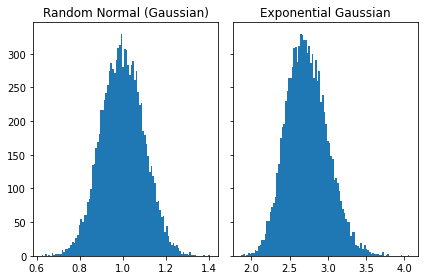

In [2]:
#gaussian and exponential gaussian 
np.random.seed(19680801)

x_s = np.random.normal(1, .1, 10000)
e_s = np.exp(x_s)

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(x_s, bins=100)
axs[1].hist(e_s, bins=100)

axs[0].title.set_text('Random Normal (Gaussian)')
axs[1].title.set_text('Exponential Gaussian')



In [18]:
# Generate data to create regression problem with 4 random gaussian vars and a y value
#mu, sigma = 0, 0.1 
x1 = np.random.normal(0, 0.1, 100)
x2 = np.random.normal(.5, 0.3, 100)
x3 = np.random.normal(1, 0.1, 100)
x4 = np.random.normal(0, 0.7, 100)
y = x1 + x2 * x3 -x4**2 + np.random.normal(0,1,100)
df1 = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'x4': x4,
    'y': y
    })
df1.head()



,x1,x2,x3,x4,y
0,-0.067786,0.691241,1.000323,-0.101434,0.865032
1,0.220851,0.613059,0.910726,-0.506674,-0.442864
2,0.044464,0.357117,1.115875,0.501301,-0.387814
3,-0.028159,0.221946,1.038368,-0.043757,0.532774
4,0.031130,0.171174,1.130465,0.912755,1.469530


In [5]:
X = df1.drop(['y'], axis=1)
y = df1.y

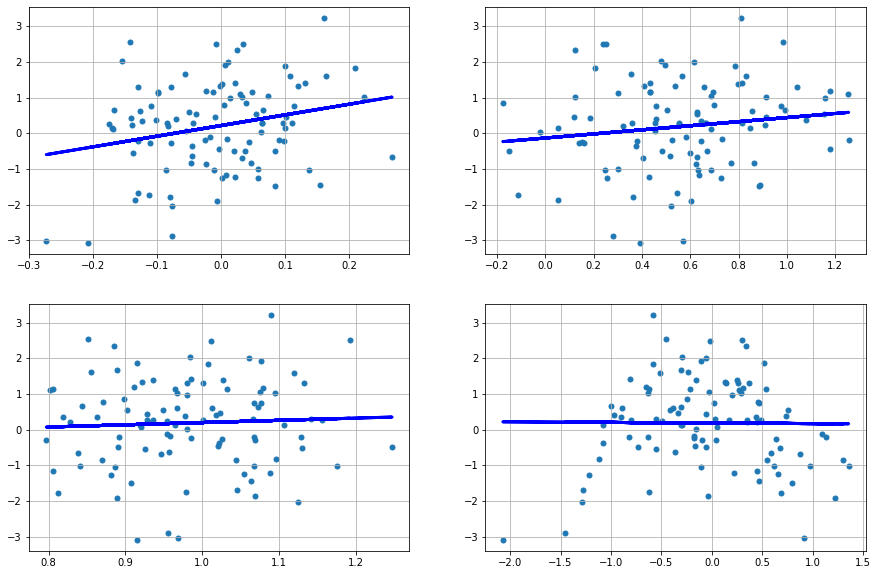

In [6]:
plt.figure(figsize=(15,10))
for i in range(1,5):
    fit = np.polyfit(df1[df1.columns[i-1]],df1['y'],1)
    fit_fn = np.poly1d(fit)
    plt.subplot(2,2,i)
    plt.scatter(df1[df1.columns[i-1]],df1['y'],s=25 )
    plt.plot(df1[df1.columns[i-1]],fit_fn(df1[df1.columns[i-1]]),'b-',lw=3)
    plt.grid(True)

## Cross validation of linear models

Different types of cross-validation that I will explore:
- leave-p-out cross validation
- leave-one-out cross validation
- repeated random sub-sampling
- k-fold cross validation

Measures of fit:
- mean squared error
- root mean squared error
- median absolute deviation

In [7]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate


In [9]:
# this is the function to generate an array of scores for a given CV method:

def get_score_list(cv):
    scores = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = svm.SVR(C=100, gamma=0.1, epsilon=.1).fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    return scores


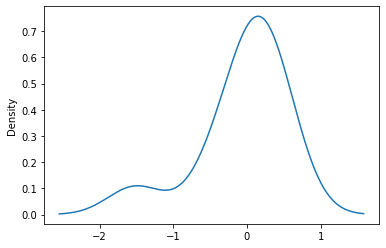

In [12]:
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split

# K-Fold cross-validation split
kf = KFold(n_splits=10, shuffle=True, random_state=1)
# Returns the number of splitting iterations in the cross-validator
kf_scores = get_score_list(kf)

ax = pd.Series(kf_scores).plot.kde()


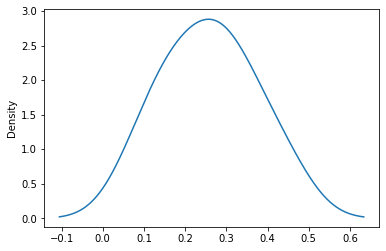

In [13]:
# Montecarlo cross-validation split
mc = ShuffleSplit(n_splits=10, test_size = 0.3 ,random_state=1)
# Returns the number of splitting iterations in the cross-validator
mc.get_n_splits(X)

mc_scores = get_score_list(mc)

ax = pd.Series(mc_scores).plot.kde()


In [14]:
from sklearn.utils import resample, check_random_state

# Single Bootstrap split
a = resample(X)
test = [item for item in X if item not in a]
print("Train:",a,"  Test:",test)

Train:           x1        x2        x3        x4
24  0.090256  1.255723  0.891351 -0.819835
63 -0.025450  0.524446  1.067137  1.131518
22  0.021364  0.429205  1.087877  0.220872
51  0.084760 -0.149638  1.247627 -0.055795
8   0.020792  0.671289  0.890200 -0.727912
..       ...       ...       ...       ...
3  -0.167351  0.504269  1.072767 -0.310458
22  0.021364  0.429205  1.087877  0.220872
16 -0.208131  0.390879  0.915814 -2.072918
26 -0.001811  0.407906  1.001651  0.137399
67 -0.129719  0.655818  0.980559  0.258510

[100 rows x 4 columns]   Test: []


In [15]:
class Bootstrap:
    
    '''Bootstrap cross validator.'''
    
    def __init__(self,n_bootstraps=5, random_state=None):
        self.nb = n_bootstraps
        self.rs = random_state
    
    def split(self, X, y=None):
        '''"""Generate indices to split data into training and test set.'''
        rng = check_random_state(self.rs)
        iX = np.mgrid[0:X.shape[0]]
        for i in range(self.nb):
            train = resample(iX, random_state=rng)
            test = [item for item in iX if item not in train]
            yield (train,test)
            

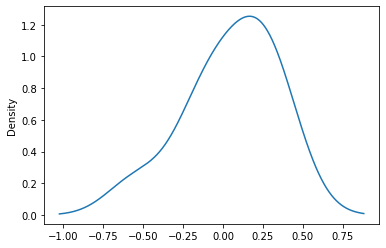

In [16]:
# Bootstrap cross-validator, consistent with similar classes in scikit-learn
boot = Bootstrap(n_bootstraps = 10, random_state=1)
boot_scores = get_score_list(boot)
ax = pd.Series(boot_scores).plot.kde()
    

<Figure size 1080x720 with 0 Axes>

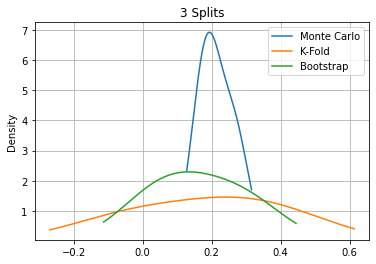

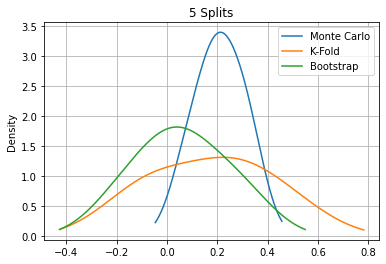

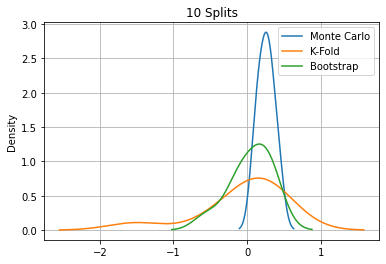

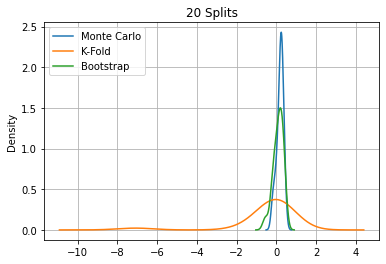

In [17]:
plt.figure(figsize=(15,10))
splits = [3,5,10,20]
for i in splits:
    
    boot = Bootstrap(n_bootstraps = i, random_state=1)
    kf = KFold(n_splits=i, shuffle=True, random_state=1)
    mc = ShuffleSplit(n_splits=i, test_size = 0.3 ,random_state=1)
    
    df = pd.DataFrame({
        'Monte Carlo': get_score_list(mc),
        'K-Fold': get_score_list(kf),
        'Bootstrap': get_score_list(boot)
    })
    ax = df.plot.kde()
    plt.title(f'{i} Splits')
    plt.grid(True)

Sources:
- [Data Generation](https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Synthetic_data_generation/Synthetic-Data-Generation.ipynb)
- [8 Types of Cross-Validation](https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d)
- [K Fold, Montecarlo, and Bootstrap](https://nirpyresearch.com/kfold-montecarlo-cross-validation-bootstrap-primer/)